## Import data

In [1]:
import numpy as np
import numpy.linalg as la
from reach import Reach
import os
import scipy.stats as stats
import sklearn.preprocessing
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt

In [2]:
#pathnames
relpron_path = './relpron_translation.txt'
verbs_path = './verbmatrices'
vectorspath = './embeddings/sonar-160.txt'

Import the RELPRON test sentences. This dataset consists of pairs of nouns and relative clauses with a transtitive verb, describing some property or action related to them. An example:

> SBJ vliegtuig: vaartuig dat hoogte bereikt/bereik
> [SBJ airplaine: craft that reaches height]

Note that items also list whether the clause is subject or object relative, and gives the root for inflected verbs (and nouns).

In [3]:
#import relpron data
relpron_file = open(relpron_path,'r', encoding='latin-1')
items_raw = relpron_file.readlines()
relpron_file.close()

In [4]:
#store relpron data

class Sentence:
    def __init__(self, string):
        key, self.propertystr = string.strip().split(': ')
        
        self.relation, self.termN = key.split(' ')
        self.rel = self.relation[0]
        
        propertylst = self.propertystr.split(' ')
        self.headN = propertylst[0]
        self.argN = propertylst[2].split('/')[0]
        _, self.V = propertylst[-1].split('/')
        
    def __str__(self):
        return self.termN + ': ' + self.propertystr
        
verbfiles = [filename[:-4] for filename in os.listdir(verbs_path)]

items = dict()
for item in items_raw:
    sent = Sentence(item)
    if sent.V + '_O' in verbfiles and sent.V + '_S' in verbfiles:
        if sent.termN not in items:
            items[sent.termN] = [sent]
        else:
            items[sent.termN].append(sent)

Loading the noun embeddings and the verb matrices

In [5]:
#load vectors
r = Reach.load(vectorspath)

#load matrices
verbmatrices = dict()
for verbfile in os.listdir(verbs_path):
    verbmatrices[verbfile[:-4]] = np.load(verbs_path+'/'+verbfile)

## Generate composed vectors

In [6]:
class PhraseComposer:
    def __init__(self, sentence):
        """Load vectors and matrices for the phrase"""
        self.relation = sentence.rel
        if self.relation == 'O':
            inverse_relation = 'S'
        else:
            inverse_relation = 'O'
        
        try:
            self.arg_v = r[sentence.argN]
            self.arg_v = self.Scale(self.arg_v)
            
            self.head_v = r[sentence.headN]
            self.head_v = self.Scale(self.head_v)
            
            self.V_v = r[sentence.V.split('_')[0]]
            self.VO_m =  verbmatrices[sent.V+'_O']
            self.VS_m = verbmatrices[sent.V+'_S']
            
            self.valid = True
        
        except KeyError:
            self.valid = False
        
        #calculate all the composed representations
        if self.valid:
            self.compositions = {'Addition' : self.Addition(),
                                 'Elementwise product' : self.EltMult(),
                                 'Head vector' : self.head_v,
                                 'Arg vector' : self.arg_v,
                                 'Verb vector' : self.V_v,
                                 'PLF': self.PLF(self.relation),
                                 'VArg': self.VArg(self.relation),
                                 'VHn': self.VHn(self.relation),
                                 'iPLF': self.PLF(inverse_relation),
                                 'iVArg': self.VArg(inverse_relation),
                                 'iVHn': self.VHn(inverse_relation)
                                }
        
    def Scale(self, v):
        """Apply standard scaling to argument vector as was done in training."""
        scaler = sklearn.preprocessing.StandardScaler()
        scaler.set_params(with_std=True)
        v = scaler.fit_transform(v[:, np.newaxis])
        v = np.squeeze(v)
        v = 0.08 * v
        return v
    
    def Compose(self, method):
        """Direct to proper composition result based on input string"""
        return self.compositions[method]
        
    def Addition(self):
        return self.head_v + self.arg_v + self.V_v
    
    def EltMult(self):
        return np.multiply(self.head_v, np.multiply(self.arg_v, self.V_v))

    def VHn(self, relation):
        if relation == 'O':
            return np.dot(self.head_v, self.VO_m)
        else:
            return np.dot(self.head_v, self.VS_m)
    
    def VArg(self, relation):
        if relation == 'O':
            return np.dot(self.arg_v, self.VS_m)
        else:
            return np.dot(self.arg_v, self.VO_m)
    
    def PLF(self, relation):
        return np.add(self.VArg(relation), self.VHn(relation))
    
    def iPLF(self):
        return(np.add(self.VArg(self.inverse_relation), self.VHn(self.inverse_relation)))         
        

In [7]:
methods_S = ['PLF', 'VHn', 'VArg', 'iPLF', 'iVHn', 'iVArg'] #methods with their result in the S space
methods_N = ['Addition', 'Elementwise product', 'Head vector', 'Arg vector', 'Verb vector'] #methods with the results in the N space
methods = methods_N + methods_S

#calculate composed representations for all sentences and methods

terms = items.keys()

results = dict()

for term in terms:
    sents = items[term]
    for sent in sents:
        composer = PhraseComposer(sent)
        if composer.valid:
            sentresults = dict()
            for method in methods:
                property_v = composer.Compose(method)
                sentresults[method] = property_v

            sentresults['target'] = r[sent.termN]
            results[sent] = sentresults
            
#remove terms with only one sentence
for term in terms:
    termcount = len([sent for sent in results if sent.termN == term])
    if termcount == 1:
        results = {sent : results[sent] for sent in results if sent.termN != term}

## Check some sizes

More of a technicality. 

Checking the number of trained verbs (bottom) is a bit cumbersome, because subject and object transformations are trained separately, and were only included if they had enough data. So some verbs have a subject but no object representation, or vice versa.

In [8]:
print('Number of terms in corpus:', len(items))

total_clauses = sum(len(items[term]) for term in items)
print('Total number of relative clauses:', total_clauses)

print('Relative clauses discarded:', total_clauses - len(results))

print('Relative clauses included in results:', len(results))

print('Average number of clauses per term:', round(len(results) / len(items), 2))

roles_for_verb = lambda key : set(verb[-1] for verb in verbmatrices if verb[:-2] == key[:-2])
verbs = {verbkey[:-2] : roles_for_verb(verbkey) for verbkey in verbmatrices}
print('Number of verbs:', len([verb for verb in verbs if len(verbs[verb]) == 2]))

Number of terms in corpus: 111
Total number of relative clauses: 411
Relative clauses discarded: 28
Relative clauses included in results: 383
Average number of clauses per term: 3.45
Number of verbs: 122


## Evaluate methods by ranking sentences based on term similarity

In [9]:
#similarity functions

def cosine(v1, v2):
    product = np.dot(v1, v2)
    norm = np.linalg.norm(v1) * np.linalg.norm(v2)
    return product / norm

def correlation(v1, v2):
    return stats.pearsonr(v1, v2)

In [10]:
#rank sentences based on similarity

def rankSentences (target_v, results_dict, method, sim_function, target_sent):
    """Returns a list of the results in the results dictionary, ranked by their similarity 
    with the target vector. Method and similarity function are parameters."""

    allsents = list(results_dict.keys())
    allsents.remove(target_sent)
    similarity = lambda sent: sim_function(target_v, results_dict[sent][method])
    return(sorted(allsents, key=similarity, reverse=True))

def evaluate_ranking(target_term, sorted_list):
    """Rate the ranking (output of rankSentences) for a sorted list using MAP. 
    The ideal ranking puts all sentences with the target term on the top. 
    Returns 1 for perfect sorting, 0 for worst sorting."""
    
    #count how many sentences in the list use the target term
    target_sents = list(filter(lambda sent: sent.termN == target_term, sorted_list))
    count = len(target_sents)
    
    errors = []
    
    for i, sent in enumerate(sorted_list):
        term = sent.termN
        if i < count:
            correct = term == target_term
            error = int(not correct) * (count - i) / count
        else:
            correct = term != target_term
            error = int(not correct) * (i + 1 - count) / (count)
        errors.append(error)
    
    return 1 - (sum(errors) / len(sorted_list))
   

Now we can apply the rankings to evaluate composition methods. If we evaluate a representation of a sentence, we rank all sentences in the corpus based on their similarity to the sentence vector. Ideally, all items with the same term are ranked on top.

To make things a bit more spicy, some the functions below allow you to pass both a base method and a "corpus method". The *base method* is used to represent the sentence, while the *corpus method* is used to represent the rest of the corpus. This way we can ask all of the following questions:
* Does PLF represent similar relative clauses close to each other?
* Does inverted PLF still represent similar clauses close to each other?
* If you invert the argument structure of a single sentence, does it still rank similarly to other, non-inverted sentences describing the same term?
Note that cross-comparing methods like this is only possible if they represent clauses in the same vector space. All methods represent clauses in the S space except for addition and elementwise multiplication, which represent it in the N space.

In [12]:
def evaluate_sent(sent, method, corpus_method, sim_function=cosine):
    """Evaluate the ranking based on the representation of a given sentence. It should rank sentence with 
    the same term on top."""
    term = sent.termN
    target_v = results[sent][method]
    ranking =  rankSentences(target_v, results, corpus_method, sim_function, sent)
    evaluation = evaluate_ranking(term, ranking)
    return evaluation

def evaluate_method(sentences, method, corpus_method = None, sim_function=cosine):
    """Evaluate a method by looping through all sentences."""
    if not corpus_method:
        corpus_method = method
        
    evaluations = [evaluate_sent(sent, method, corpus_method, sim_function) for sent in sentences]
    return np.array(evaluations)

So how do the methods compare?

In [13]:
#calculate evaluations

method_results = { method : np.array(evaluate_method(results.keys(), method)) for method in methods }

               Addition 0.9649274547214481
    Elementwise product 0.7800890892083325
            Head vector 0.964738516078174
             Arg vector 0.759930751790279
            Verb vector 0.583515876379122
                    PLF 0.7253815226143772
                    VHn 0.7499189240033771
                   VArg 0.6928904552949363
                   iPLF 0.721694127051392
                   iVHn 0.7558786444327706
                  iVArg 0.660145647120549

Ranking accuracy for each method


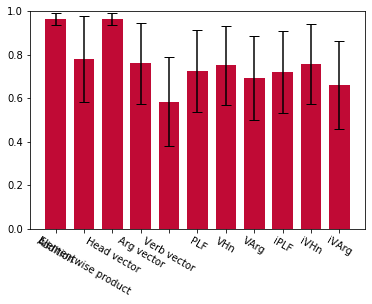

In [14]:
#descriptives
mean_acc =  [ np.mean(method_results[method]) for method in method_results ]
sd_acc = [ np.std(method_results[method]) for method in method_results ]

ticks = np.linspace(0,len(methods),num=len(methods))

#plot
plt.bar(ticks, mean_acc, yerr = sd_acc, capsize = 5, color = '#C00A35')
plt.ylim((0,1))
plt.xticks(ticks, methods, rotation=-30)

#print descriptives
for i, method in enumerate(methods):
    print(' ' * (20 - len(method)), ' ', method, mean_acc[i])
    
      
print()
print('Ranking accuracy for each method')

In [15]:
#old code:
#evaluate based on similarity between property vectors and term vectors 
#(only useful for addition and elementwise product)

terms = {sent.termN : results[sent]['target'] for sent in results.keys()}

def evaluate_term(term, target_v, method='Addition', sim_function=cosine):
    ranking = rankSentences(target_v, results, method, sim_function, None)
    evaluation = evaluate_ranking(term, ranking)
    return evaluation

def evaluate_method_by_term(method='Addition', sim_function=cosine):
    evaluations = [evaluate_term(term, terms[term], method, sim_function) for term in terms]
    return round(sum(evaluations) / len(terms), 3)

#print(evaluate_method_by_term('Addition'))
#print(evaluate_method_by_term('Elementwise product'))

## Similarity to PLF

In the last section, we looked at composition methods in isolation. We notice that most of them represent semantic distance pretty well! But does that mean that their results are similar to the PLF results? Or are they preserving distance in their own space?

One way to see this: how do they rank PLF results? PLF will give the same results as above (or something is wrong). The other methods essentially represent some loss of information: we only consider the head noun, we only consider the argument, or we mess up the argument structure.

In [16]:
print('\t\t\tranking')

for method in methods_S:
    print(' ' * (16 - len(method)) + method, 
          round(np.mean(evaluate_method(results.keys(), method = method, corpus_method = 'PLF')), 3),
          sep='\t')

			ranking
             PLF	0.725
             VHn	0.723
            VArg	0.7
            iPLF	0.719
            iVHn	0.723
           iVArg	0.674


These numbers are still really high! Let's look at the direct similarity with the PLF results.

In [17]:
def compare_methods(method_1, method_2, sim_function = cosine):
    similarities = [sim_function(results[sent][method_1], results[sent][method_2]) for sent in results]
    return similarities

methods_compared_to_PLF = {method : compare_methods(method, 'PLF') for method in methods_S}

                    PLF 1.0
                    VHn 0.9579806160035399
                   VArg 0.9493473555771804
                   iPLF 0.9680602480318826
                   iVHn 0.924871145461425
                  iVArg 0.9134799631932279

Ranking accuracy for each method


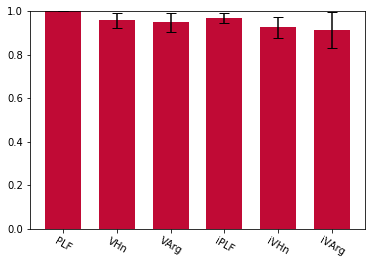

In [20]:
#descriptives
mean_corr =  [ np.mean(methods_compared_to_PLF[method]) for method in methods_S ]
sd_corr = [ np.std(methods_compared_to_PLF[method]) for method in methods_S ]

ticks = np.linspace(0,len(methods_S),num=len(methods_S))

#plot
plt.bar(ticks, mean_corr, yerr = sd_corr, capsize = 5, color = '#C00A35')
plt.ylim((0,1))
plt.xticks(ticks, methods_S, rotation=-30)

#print descriptives
for i, method in enumerate(methods_S):
    print(' ' * (20 - len(method)), ' ', method, mean_corr[i])
    
    
print()
print('Ranking accuracy for each method')

In [41]:
import matplotlib.font_manager

[font.name for font in matplotlib.font_manager.fontManager.ttflist]

['STIXSizeOneSym',
 'STIXSizeTwoSym',
 'DejaVu Sans Mono',
 'cmex10',
 'STIXSizeOneSym',
 'STIXGeneral',
 'DejaVu Sans',
 'STIXSizeFourSym',
 'DejaVu Serif',
 'cmr10',
 'STIXSizeThreeSym',
 'DejaVu Sans',
 'STIXSizeTwoSym',
 'cmsy10',
 'STIXSizeFourSym',
 'STIXSizeThreeSym',
 'STIXNonUnicode',
 'cmss10',
 'STIXGeneral',
 'DejaVu Sans Mono',
 'STIXGeneral',
 'STIXNonUnicode',
 'DejaVu Serif',
 'DejaVu Sans Display',
 'DejaVu Serif',
 'cmtt10',
 'DejaVu Sans',
 'DejaVu Serif Display',
 'DejaVu Sans Mono',
 'cmb10',
 'cmmi10',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXNonUnicode',
 'STIXSizeFiveSym',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Sans']

Comparison between baseline and PLF


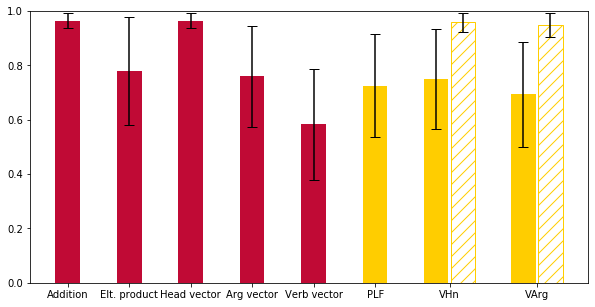

In [33]:
#make a nice graph of non-inverted data

#declare colours

c1 = '#C00A35'
c2 = '#FFCD00'
c3 = '#24A793'

#get data

#baseline methods
baseline_methods = methods_N
baseline_mean_acc = mean_acc[:len(baseline_methods)]
baseline_sd_acc = sd_acc[:len(baseline_methods)]
baseline_ticks = np.array(range(len(baseline_methods)))

#PLF
plf_mean_acc = mean_acc[len(baseline_methods)]
plf_sd_acc = sd_acc[len(baseline_methods)]
plf_ticks = np.array([len(baseline_methods)])

#methods VHn and VArg, which match the colour of PLF but include the correlation with PLF
rest_methods = methods[6:8]
rest_start = len(baseline_methods) + 1
rest_end = rest_start + len(rest_methods)
rest_mean_acc = mean_acc[rest_start: rest_end]
rest_sd_acc = sd_acc[rest_start: rest_end]
rest_mean_corr = mean_corr[1 : len(rest_methods) + 1]
rest_sd_corr = sd_corr[1 : len(rest_methods) + 1]
rest_ticks = np.array(range(rest_start, rest_end))

#set bar width
bar_width = 0.4
bar_spacing = 0.02

#rescale rest_ticks
rest_ticks_shift = np.array(range(len(rest_ticks))) * (bar_width + bar_spacing)
rest_ticks_shift = rest_ticks_shift + bar_width / 2 + bar_spacing / 2
rest_ticks = rest_ticks + rest_ticks_shift

#make bars

plt.figure(figsize = (10,5))

plt.bar(baseline_ticks, baseline_mean_acc,  yerr = baseline_sd_acc, capsize = 5, 
        width = bar_width, color = c1)
plt.bar(plf_ticks, plf_mean_acc,  yerr = plf_sd_acc, capsize = 5, 
        width = bar_width, color = c2)
plt.bar(rest_ticks - 0.22, rest_mean_acc,  yerr = rest_sd_acc, capsize = 5, 
        width = bar_width, color = c2)
plt.bar(rest_ticks + 0.22, rest_mean_corr, yerr = rest_sd_corr, capsize = 5, 
        width = bar_width, fill = False, hatch = '//', edgecolor = c2)

#add tick labels 

tick_labels = baseline_methods + ['PLF'] + rest_methods
tick_labels[1] = 'Elt. product'
all_ticks = np.hstack((baseline_ticks, plf_ticks, rest_ticks))
plt.xticks(all_ticks, tick_labels)

#additional stuff

plt.ylim(0,1)

print('Comparison between baseline and PLF')

Effect of inverting argument structure


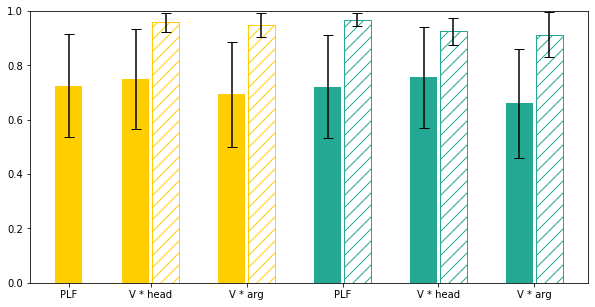

In [35]:
#similar to above, but we leave out the lexical baselines and include the inverted data

#get data. much of this does not need to be repeated

plf_ticks = np.array([0])

rest_ticks = np.array(range(1, 1 + len(rest_methods)))

#inverted data
inv_methods = methods[rest_end:]
inv_mean_acc = mean_acc[rest_end:]
inv_sd_acc = sd_acc[rest_end:]
inv_mean_corr = mean_corr[len(rest_methods) + 1 :]
inv_sd_corr = sd_corr[len(rest_methods) + 1 :]
inv_ticks = range(1 + len(rest_methods), 1 + len(rest_methods) + len(inv_methods))

bar_width = 0.4
bar_spacing = 0.02

#rescale rest and inverted ticks
rest_ticks_shift = np.array(range(len(rest_ticks))) * (bar_width + bar_spacing)
rest_ticks_shift = rest_ticks_shift + bar_width / 2 + bar_spacing / 2
rest_ticks = rest_ticks + rest_ticks_shift

inv_ticks_shift = np.array(range(1, len(inv_ticks) + 1)) * (bar_width + bar_spacing)
inv_ticks_shift = inv_ticks_shift + rest_ticks_shift[-1]  
inv_ticks = inv_ticks + inv_ticks_shift

#make bars

plt.figure(figsize = (10,5))

plt.bar(plf_ticks, plf_mean_acc,  yerr = plf_sd_acc, 
        capsize = 5, width = bar_width, color = c2)
plt.bar(rest_ticks - 0.22, rest_mean_acc,  yerr = rest_sd_acc, 
        capsize = 5, width = bar_width, color = c2)
plt.bar(rest_ticks + 0.22, rest_mean_corr, yerr = rest_sd_corr, 
        capsize = 5, width = bar_width, fill = False, hatch = '//', edgecolor = c2)
plt.bar(inv_ticks - 0.22, inv_mean_acc, yerr = inv_sd_acc, 
        capsize = 5, width = bar_width, color = c3)
plt.bar(inv_ticks + 0.22, inv_mean_corr, yerr = inv_sd_corr, 
        capsize = 5, width = bar_width, fill = False, hatch = '//', edgecolor = c3)

#add tick labels 

#tick_labels = ['PLF'] + rest_methods + inv_methods
tick_labels = ['PLF', 'V * head', 'V * arg'] * 2
all_ticks = np.hstack((plf_ticks, rest_ticks, inv_ticks))
plt.xticks(all_ticks, tick_labels)

#additional stuff

plt.ylim(0,1)

print('Effect of inverting argument structure')